# 1. 基础操作

In [ ]:
import tensorflow as tf

In [ ]:
tf.random.uniform(shape = ())

<tf.Tensor: shape=(), dtype=float32, numpy=0.19983757>

In [ ]:
tf.zeros(shape=(2), dtype=tf.float32)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [ ]:
A = tf.random.normal(shape = (2,2))
A.numpy()

array([[ 0.36110538, -1.1769955 ],
       [-1.1967709 , -2.1535163 ]], dtype=float32)

# 2. 自动求导

In [ ]:
# 简单的y = x^2 求导
x = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  y = tf.square(x)
y_grad = tape.gradient(y, x)
print([y, y_grad])

[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=6.0>]


In [ ]:
# 多元函数求偏导
X = tf.constant([[1.,2.], [3., 4.]])
y = tf.constant( [[1.], [2.]])
w = tf.Variable(initial_value=[[1.], [2.]])
b = tf.Variable(initial_value=1.)
with tf.GradientTape() as tape:
  L = tf.reduce_sum(tf.square( tf.matmul(X, w) + b - y ))
w_grad, b_grad = tape.gradient(L, [w, b])
print(L, w_grad, b_grad)

tf.Tensor(125.0, shape=(), dtype=float32) tf.Tensor(
[[ 70.]
 [100.]], shape=(2, 1), dtype=float32) tf.Tensor(30.0, shape=(), dtype=float32)


# 3. 基础示例: 线性回归

In [ ]:
# 定义数据
import numpy as np
X_raw = np.arange(2013, 2018, dtype = np.float32)
y_raw = np.array([12000, 14000, 15000, 16500, 17500], dtype = np.float32)

#对数据放缩到[0,1]之间
X = (X_raw - X_raw.min())/(X_raw.max() - X_raw.min())
y = (y_raw - y_raw.min())/(y_raw.max() - y_raw.min())

问题:  
    回顾机器学习知识，使用梯度下降法,对于多元函数$f(x)$，求局部最小值

## 3.1 先用自己的理解，使用tensorflow现有学习的知识练习一遍  
Note: Tensorflow对变量tf.Variable的赋值要使用assign，且shape应该一致

In [ ]:
X_tensor = tf.constant(X, dtype=tf.float32)
y_tensor = tf.constant(y, dtype=tf.float32)
w = tf.Variable(initial_value=0.5, dtype = tf.float32)
b = tf.Variable(initial_value=0.0, dtype=tf.float32)
lr = 1e-3
L_progress = []
for i in range(1000):
  with tf.GradientTape() as tape:
    L = tf.reduce_sum( tf.square( tf.multiply(w, X_tensor) + b - y ))
  w_grad, b_grad = tape.gradient(L, [w,b])
  L_progress.append(L.numpy())
  w.assign(w - tf.multiply(lr,w_grad))
  b.assign(b - tf.multiply(lr,b_grad))

In [ ]:
import matplotlib.pyplot as plt

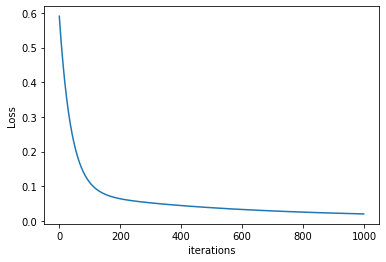

In [ ]:
plt.plot(list(range(len(L_progress))), L_progress)
plt.xlabel(r'iterations')
plt.ylabel(r'Loss')
plt.show()

## 3.2 使用Tensorflow的Optimizer尝试一遍

In [ ]:
X_tensor = tf.constant(X, dtype = tf.float32)
y_tensor = tf.constant(y, dtype = tf.float32)

a = tf.Variable(initial_value=0.)
b = tf.Variable(initial_value=0.)
variables = [ a, b]
num_epochs = 10000 # 这里改成迭代1w次，因为1k次b的值仍然没有稳定
lr = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
a_progress = []
b_progress = []
L_progress = []
for e in range(num_epochs):
  with tf.GradientTape() as tape:
    y_pred = a*X + b
    loss = tf.reduce_sum( tf.square(y_pred - y))
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(grads_and_vars = zip(grads, variables))
  a_progress.append(variables[0].numpy())
  b_progress.append(variables[1].numpy())
  L_progress.append(loss.numpy())


Text(0, 0.5, 'loss')

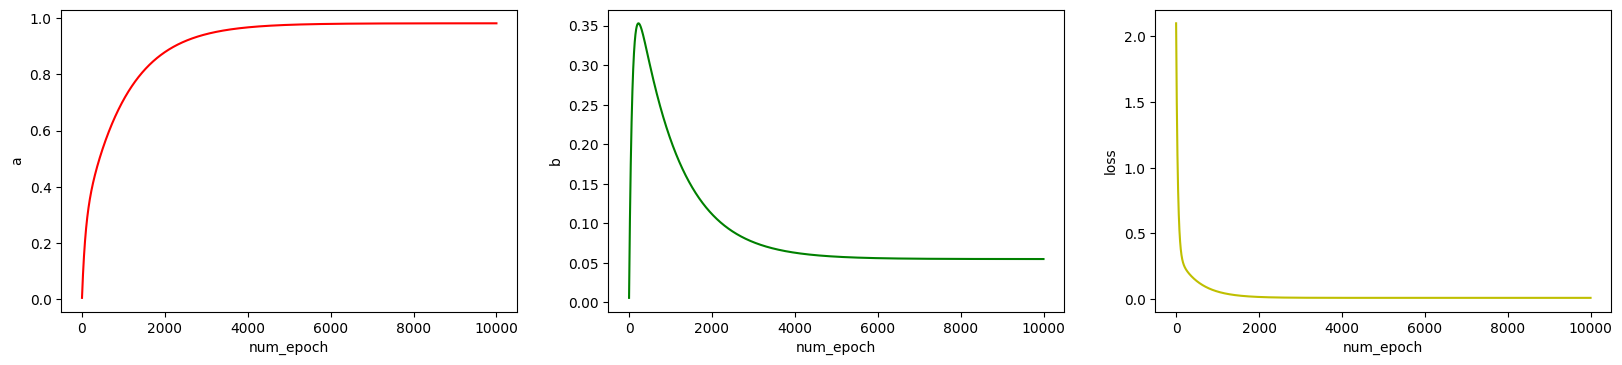

In [ ]:
# 将参数a、b以及损失loss的图像画出来
fig = plt.figure(figsize=(20,4),dpi = 100)
plt.subplot(1,3,1)
plt.plot(list(range(num_epochs)), a_progress, 'r-')
plt.xlabel(r'num_epoch')
plt.ylabel(r'a')
plt.subplot(1,3,2)
plt.plot(list(range(num_epochs)), b_progress, 'g-')
plt.xlabel(r'num_epoch')
plt.ylabel(r'b')
plt.subplot(1,3,3)
plt.plot(list(range(num_epochs)), L_progress, 'y-')
plt.xlabel(r'num_epoch')
plt.ylabel(r'loss')

# 4. 模型建立和训练  
这里我们使用tf.keras构建模型  
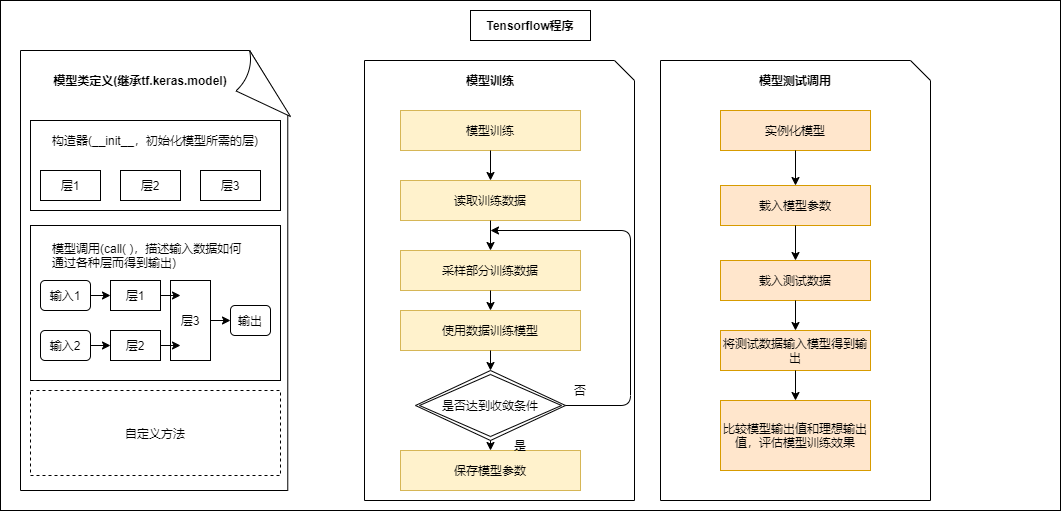

In [ ]:
# 模型模板
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__() # python2下使用super(MyModel, self).__init__()
    # 此处添加初始化代码（包含call()方法中会用到的层），例如
    # layer1 = tf.keras.layers.BuiltInLayer(...)
    # layer2 = MyCustomLayer(...)
  
  def call(self, input):
    output = None
    # 此处添加模型调用的代码（处理输入并返回输出），例如
    # x = layer1(input)
    # output = layer2(x)
    return output


继承tf.keras.Model类后，就 可以使用父类的一些属性和方法。  
比如：model = Model()，可以通过model.variables获得模型所有变量

## 4.1 将$y_{pred} = a\times x+b$写成模型形式

In [ ]:
X = tf.constant([[1.0, 2.0, 3.0],[4.0, 5.0, 6.0]])
y = tf.constant([[10.0],[20.0]])

In [ ]:
class Linear(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense = tf.keras.layers.Dense(
        units = 1,
        activation = None,
        kernel_initializer = tf.zeros_initializer(),
        bias_initializer = tf.zeros_initializer()
    )
  def call(self, input):
    output = self.dense(input)
    return output

In [ ]:
model = Linear()
model.variables
# 未显示，没有初始化参数

[]

In [ ]:
lr = 1e-3
num_epochs = 1000
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

#记录变量变化
L_progress = []

for i in range(num_epochs):
  with tf.GradientTape() as tape:
    y_pred = model(X)
    loss = tf.reduce_sum( tf.square( y_pred - y))
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients( grads_and_vars = zip( grads,model.variables))
  L_progress.append(loss.numpy())

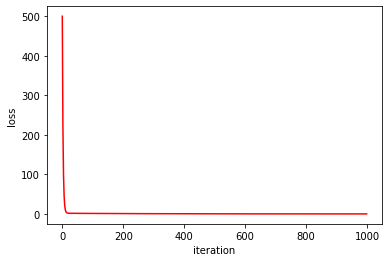

In [ ]:
plt.plot(list(range(num_epochs)), L_progress, 'r-')
plt.xlabel(r'iteration')
plt.ylabel(r'loss')
plt.show()

## 4.2 多层感知机  
运用Tensorflow模型框架实现MLP

### 4.2.1 数据预处理tf.keras.datasets

In [ ]:
class MNISTLoader():
  def __init__(self):
    mnist = tf.keras.datasets.mnist
    (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
    self.train_data = np.expand_dims(self.train_data.astype(np.float32)/255.0, axis = -1)
    self.test_data = np.expand_dims(self.test_data.astype(np.float32)/255.0, axis = -1)
    self.train_label = self.train_label.astype(np.int32)
    self.test_label = self.test_label.astype(np.int32)
    self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

  def get_batch(self, batch_size):
    index = np.random.randint(0, np.shape(self.train_data)[0], batch_size)
    return self.train_data[index,:], self.train_label[index]

In [ ]:
class MLP(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units = 100, activation = tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(units = 10)

  def call(self, inputs):
    x = self.flatten(inputs)
    x = self.dense1(x)
    x = self.dense2(x)
    output = tf.nn.softmax(x)
    return output

In [ ]:
#
num_epochs = 50
batch_size = 50
lr = 1e-3
loss_progress = []

In [ ]:
model = MLP()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [ ]:
def one_hot_encoding( inputs, depth):
  one_hot = np.zeros((inputs.shape[0], depth))
  one_hot[(np.arange(one_hot.shape[0]), inputs)] = 1
  return one_hot

In [ ]:
a = list(range(10))
ont_hot_encoding(np.array(a), 10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for epoch in range(num_epochs):
  for itr in range(data_loader.num_train_data//batch_size):
    X, y = data_loader.get_batch(batch_size = batch_size)
    with tf.GradientTape() as tape:
      y_pred = model(X)
      #loss = tf.reduce_sum( tf.nn.softmax_cross_entropy_with_logits(one_hot_encoding(y, 10), y_pred, axis = -1) )
      loss = tf.keras.losses.sparse_categorical_crossentropy(y_true = y, y_pred = y_pred)
      loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars = zip( grads, model.variables))
  print('Epoch %d Loss %f'%(epoch, loss.numpy()))
  loss_progress.append(loss.numpy())

Epoch 0 Loss 0.859288
Epoch 1 Loss 0.839983
Epoch 2 Loss 0.570361
Epoch 3 Loss 0.447669
Epoch 4 Loss 0.463764
Epoch 5 Loss 0.587014
Epoch 6 Loss 0.387574
Epoch 7 Loss 0.420844
Epoch 8 Loss 0.459220
Epoch 9 Loss 0.308882
Epoch 10 Loss 0.399030
Epoch 11 Loss 0.418317
Epoch 12 Loss 0.375267
Epoch 13 Loss 0.477444
Epoch 14 Loss 0.241123
Epoch 15 Loss 0.353803
Epoch 16 Loss 0.300701
Epoch 17 Loss 0.286820
Epoch 18 Loss 0.218796
Epoch 19 Loss 0.313626
Epoch 20 Loss 0.244513
Epoch 21 Loss 0.456707
Epoch 22 Loss 0.498148
Epoch 23 Loss 0.587246
Epoch 24 Loss 0.193012
Epoch 25 Loss 0.283111
Epoch 26 Loss 0.504135
Epoch 27 Loss 0.621668
Epoch 28 Loss 0.229532
Epoch 29 Loss 0.356168
Epoch 30 Loss 0.198845
Epoch 31 Loss 0.280969
Epoch 32 Loss 0.268773
Epoch 33 Loss 0.414477
Epoch 34 Loss 0.273968
Epoch 35 Loss 0.234665
Epoch 36 Loss 0.395774
Epoch 37 Loss 0.312089
Epoch 38 Loss 0.290877
Epoch 39 Loss 0.293107
Epoch 40 Loss 0.295849
Epoch 41 Loss 0.182665
Epoch 42 Loss 0.267717
Epoch 43 Loss 0.27564

In [ ]:
loss_progress = loss_progress[-50:]

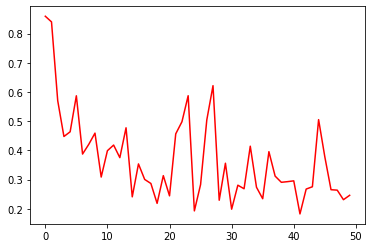

In [ ]:
plt.plot(list(range(num_epochs)), loss_progress, 'r-')
plt.show()

In [ ]:
# loss = tf.keras.losses.categorical_crosstropy(
#    y_true = tf.one_hot(y, depth = tf.shape(y_pred)[-1]),
#    y_pred = y_pred
#)

## 4.3 模型评估  
使用tf.keras.metrics中的SparseCategoricalAccuracy

In [ ]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data//batch_size)
for batch_index in range(num_batches):
  start_index, end_index = batch_index * batch_size, (batch_index + 1)*batch_size
  y_pred = model.predict(data_loader.test_data[start_index:end_index])
  sparse_categorical_accuracy.update_state(
      y_true = data_loader.test_label[start_index:end_index],
      y_pred = y_pred
  )
print("Test accuracy: %f"%sparse_categorical_accuracy.result())

Test accuracy: 0.929200


## 4.4 卷积神经网络  
卷积层、池化层、全连接层

### 4.4.1 使用keras实现卷积神经网络

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class CNN(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.conv1 = tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = [5,5],
        padding = 'same',
        activation = tf.nn.relu
    )
    self.pool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2)
    self.conv2 = tf.keras.layers.Conv2D(
        filters = 64,
        kernel_size = [5,5],
        padding = 'same',
        activation = tf.nn.relu
    )
    self.pool2 = tf.keras.layers.MaxPool2D( pool_size=(2,2), strides = 2)
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(units = 1024, activation = tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(units=10)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    output = tf.nn.softmax(x)
    return output

使用前面的训练、测试模板对模型进行训练和评估

In [ ]:
num_epochs = 50
batch_size = 64
lr = 1e-3
Loss_progress = []
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
data_loader = MNISTLoader()

model = CNN()

for epoch_idx in range(num_epochs):
  for idx in range(int(data_loader.num_train_data//batch_size)):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
      y_pred = model(X)
      loss = tf.keras.losses.sparse_categorical_crossentropy(
          y_true = y,
          y_pred = y_pred
      )
      loss = tf.reduce_mean(loss)
    grads = tape.gradient( loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
  Loss_progress.append(loss.numpy())
  print("Epoch %d Loss %f"%( epoch_idx, loss.numpy()))

Epoch 0 Loss 2.077006
Epoch 1 Loss 0.793056
Epoch 2 Loss 0.591769
Epoch 3 Loss 0.417728
Epoch 4 Loss 0.280251
Epoch 5 Loss 0.193021
Epoch 6 Loss 0.223529
Epoch 7 Loss 0.129333
Epoch 8 Loss 0.169597
Epoch 9 Loss 0.148418
Epoch 10 Loss 0.100614
Epoch 11 Loss 0.104290
Epoch 12 Loss 0.152859
Epoch 13 Loss 0.077907
Epoch 14 Loss 0.082257
Epoch 15 Loss 0.110603
Epoch 16 Loss 0.136516
Epoch 17 Loss 0.095091
Epoch 18 Loss 0.299606
Epoch 19 Loss 0.108360
Epoch 20 Loss 0.085134
Epoch 21 Loss 0.055096
Epoch 22 Loss 0.025816
Epoch 23 Loss 0.125406
Epoch 24 Loss 0.080554
Epoch 25 Loss 0.147145
Epoch 26 Loss 0.082579
Epoch 27 Loss 0.158249
Epoch 28 Loss 0.141315
Epoch 29 Loss 0.016933
Epoch 30 Loss 0.136265
Epoch 31 Loss 0.117167
Epoch 32 Loss 0.035248
Epoch 33 Loss 0.028594
Epoch 34 Loss 0.047068
Epoch 35 Loss 0.060061
Epoch 36 Loss 0.081311
Epoch 37 Loss 0.049536
Epoch 38 Loss 0.099812
Epoch 39 Loss 0.117309
Epoch 40 Loss 0.188267
Epoch 41 Loss 0.040734
Epoch 42 Loss 0.013568
Epoch 43 Loss 0.03447

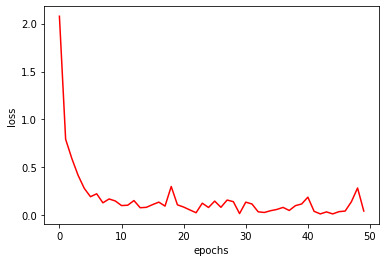

In [ ]:
plt.plot(list(range(num_epochs)), Loss_progress, 'r-')
plt.xlabel(r'epochs')
plt.ylabel(r'loss')
plt.show()

In [ ]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data//batch_size)
for batch_index in range(num_batches):
  start_index, end_index = batch_index * batch_size, (batch_index + 1)*batch_size
  y_pred = model.predict(data_loader.test_data[start_index:end_index])
  sparse_categorical_accuracy.update_state(
      y_true = data_loader.test_label[start_index:end_index],
      y_pred = y_pred
  )
print("Test accuracy: %f"%sparse_categorical_accuracy.result())

Test accuracy: 0.980268


### 4.4.2 使用keras预定义的经典神经网络结构  
    
[tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en) 包括：densenet、resnet、mobilenet(v1、v2、v3）、vgg（16、19）、Xception等

In [ ]:
model = tf.keras.applications.VGG16()

In [ ]:
# 查看模型结构
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
num_epochs = 5
batch_size = 24
lr = 1e-6

In [ ]:
dataset = tfds.load("tf_flowers", split = tfds.Split.TRAIN, as_supervised=True)

In [ ]:
dataset = dataset.map(lambda img, label: ( tf.image.resize(img, (224, 224))/255.0, label)).shuffle(1024).batch(batch_size)

In [ ]:
#model = tf.keras.applications.MobileNetV2(weights = None, classes = 5)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
loss_progress = []
cnt = 0
for e_idx in range(num_epochs):
  loss = None
  print("="*10, end = '')
  print("Epoch %d"%e_idx, end = '')
  print("="*10)
  for images, labels in dataset:
    with tf.GradientTape() as tape:
      y_pred = model(images)
      loss = tf.keras.losses.sparse_categorical_crossentropy(
          y_true = labels,
          y_pred = y_pred
      )
      loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
    
    #print("Iteration %3d Loss %f"%(cnt, loss.numpy()))
    #cnt += 1
  optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
  loss_progress.append(loss.numpy())
  print("Epoch %d Loss %f"%(e_idx, loss.numpy()))

==========Epoch 0==========
Epoch 0 Loss 1.180372
==========Epoch 1==========
Epoch 1 Loss 0.853532
==========Epoch 2==========
Epoch 2 Loss 0.716593
==========Epoch 3==========
Epoch 3 Loss 0.425987
==========Epoch 4==========
Epoch 4 Loss 0.384968


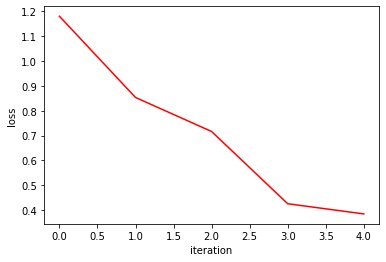

In [ ]:
plt.plot(list(range(len(loss_progress))), loss_progress, 'r-')
plt.xlabel(r'iteration')
plt.ylabel(r'loss')
plt.show()

In [ ]:
test_dataset = tfds.load("tf_flowers", split = tfds.Split.TRAIN, as_supervised=True)
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
test_dataset = test_dataset.map(lambda img, label: ( tf.image.resize(img, (224, 224))/255.0, label)).batch(batch_size)

In [ ]:
for images, labels in test_dataset:
  y_pred = model.predict(images)
  sparse_categorical_accuracy.update_state(
      y_true = labels,
      y_pred = y_pred
  )
print("Train Accuracy: %f"%sparse_categorical_accuracy.result())

Train Accuracy: 0.873025


## 4.5 循环神经网络  
Recurrent Neural Network，处理序列数据

In [ ]:
import tensorflow as tf
import numpy as np
from collections import Counter

In [ ]:
A = "akdfjsafjasdlasdjfkl saddjflkasdjflasjdf "
A = A.replace(' ','')
A_cnt = Counter(A).items()
A_cnt
sorted(A_cnt, key = lambda x:x[1],reverse=True)

[('a', 7), ('d', 7), ('f', 6), ('j', 6), ('s', 6), ('l', 4), ('k', 3)]

In [ ]:
class DataLoader():
  def __init__(self):
    path = tf.keras.utils.get_file('nietzsche.txt', origin = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
    with open(path, encoding = 'utf-8') as f:
      self.raw_text = f.read().lower()
    #encoding by most used
    #raw_text_cnt = Counter(self.raw_text).items()
    #chars_sorted = sorted(raw_text_cnt, key=lambda x:x[1], reverse=True)
    #self.chars = [x[0] for x in chars_sorted]
    self.chars = sorted(list(set(self.raw_text)))
    self.char_indices = dict((c,i) for i,c in enumerate(self.chars))
    self.indices_char = dict((i,c) for i,c in enumerate(self.chars))
    self.text = [self.char_indices[c] for c in self.raw_text]

  def get_batch(self, seq_length, batch_size):
    seq = []
    next_char = []
    for i in range(batch_size):
      index = np.random.randint(0, len(self.text) - seq_length)
      seq.append(self.text[index:index+seq_length])
      next_char.append(self.text[index+seq_length])
    return np.array(seq), np.array(next_char)

In [ ]:
class RNN(tf.keras.Model):
  def __init__(self, num_chars, batch_size, seq_length):
    super().__init__()
    self.num_chars = num_chars
    self.seq_length = seq_length
    self.batch_size = batch_size
    self.cell = tf.keras.layers.LSTMCell(units=256)
    self.dense = tf.keras.layers.Dense(units=self.num_chars)

  def call(self, inputs, from_logits = False):
    inputs = tf.one_hot(inputs, depth=self.num_chars)
    state = self.cell.get_initial_state( batch_size = self.batch_size, dtype = tf.float32)
    for t in range(self.seq_length):
      output, state = self.cell(inputs[:, t, :], state )
    logits = self.dense(output)
    if from_logits:
      return logits
    else:
      return tf.nn.softmax(logits)
  
  def predict(self, inputs, temperature = 1.):
    batch_size,_ = tf.shape(inputs)
    logits = self(inputs, from_logits = True)
    prob = tf.nn.softmax(logits/temperature).numpy()
    return np.array([np.random.choice(self.num_chars, p = prob[i,:]) for i in range(batch_size.numpy())])
  

In [ ]:
data_loader = DataLoader()

In [ ]:
num_batches = 2000
seq_length = 40
batch_size = 100
num_epoch = 10
learning_rate = 1e-3

In [ ]:
model = RNN(
    num_chars=len(data_loader.chars),
    batch_size = batch_size,
    seq_length = seq_length)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
X, y = data_loader.get_batch(seq_length, batch_size)

In [ ]:
X.shape, y.shape

((100, 40), (100,))

In [ ]:
import matplotlib.pyplot as plt
import time

==========Epoch 0==========
Epoch 0 batch 1999: loss 2.134439
Time cost: 138


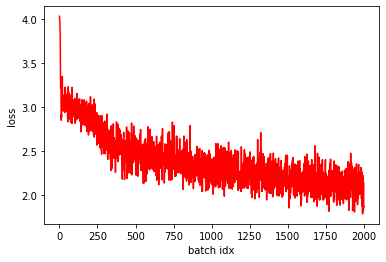

==========Epoch 1==========
Epoch 1 batch 1999: loss 1.844952
Time cost: 138


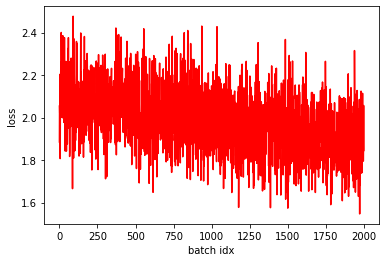

==========Epoch 2==========
Epoch 2 batch 1999: loss 1.682746
Time cost: 137


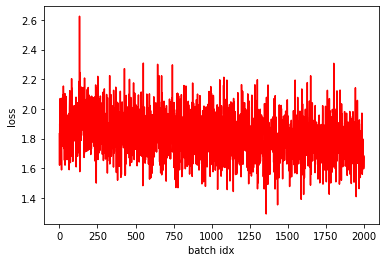

==========Epoch 3==========
Epoch 3 batch 1999: loss 1.600793
Time cost: 136


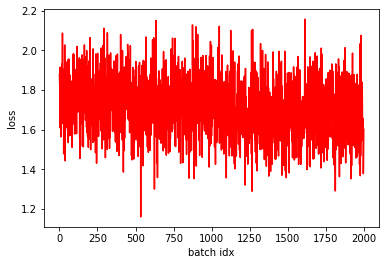

==========Epoch 4==========
Epoch 4 batch 1999: loss 1.487493
Time cost: 137


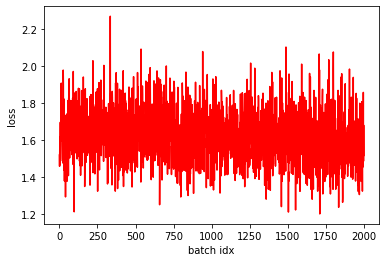

==========Epoch 5==========
Epoch 5 batch 1999: loss 1.490467
Time cost: 137


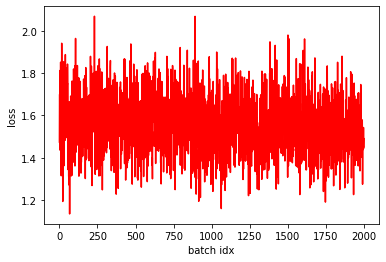

==========Epoch 6==========
Epoch 6 batch 1999: loss 1.709647
Time cost: 137


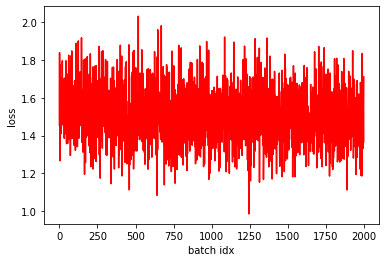

==========Epoch 7==========
Epoch 7 batch 1999: loss 1.446940
Time cost: 137


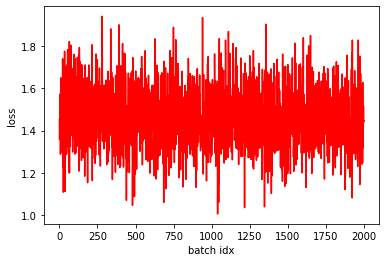

==========Epoch 8==========
Epoch 8 batch 1999: loss 1.581140
Time cost: 138


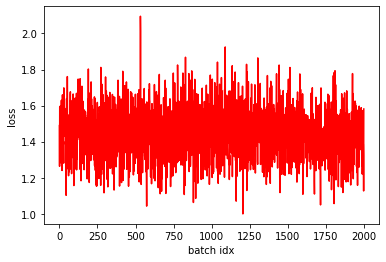

==========Epoch 9==========
Epoch 9 batch 1999: loss 1.478311
Time cost: 138


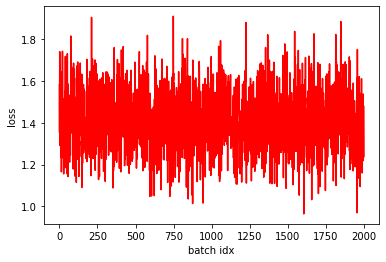

In [ ]:
for e_idx in range(num_epoch):
  loss_process = []
  print('='*10, end='')
  print('Epoch %d'%(e_idx), end='')
  print('='*10)
  time_start = time.time()
  for batch_idx in range(num_batches):
    X, y = data_loader.get_batch(seq_length, batch_size)
    with tf.GradientTape() as tape:
      y_pred = model(X)
      loss = tf.keras.losses.sparse_categorical_crossentropy( y_true = y, y_pred = y_pred)
      loss = tf.reduce_mean(loss)
    print('\rEpoch %d batch %d: loss %f'%( e_idx, batch_idx, loss.numpy()), end = '')
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    loss_process.append(loss.numpy())
  print()
  time_end = time.time()
  print('Time cost: %d'%(time_end - time_start))
  #plt.subplot( 5, 2, e_idx+1)
  plt.plot(list(range(num_batches) ), loss_process, 'r-')
  plt.xlabel(r'batch idx')
  plt.ylabel(r'loss')
  plt.show()

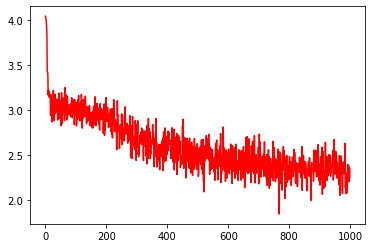

In [ ]:
#迭代1000次的显示结果
import matplotlib.pyplot as plt
plt.plot(list(range(len(loss_process))), loss_process, 'r-')
plt.show()

In [ ]:
# 模型保存
checkpoint = tf.train.Checkpoint(myModel = model)
checkpoint.save('./model/model.ckptb')

'./model/model.ckpt-1'

In [ ]:
# 模型恢复
num_batches = 2000
seq_length = 40
batch_size = 100
model = RNN(
    num_chars=len(data_loader.chars),
    batch_size = batch_size,
    seq_length = seq_length)
checkpoint = tf.train.Checkpoint(myModel = model)
checkpoint.restore(tf.train.latest_checkpoint('./model'))

In [ ]:
# 测试下batch值
X, y = data_loader.get_batch(seq_length, batch_size)
for j in range(X.shape[0]):
  print(''.join([data_loader.indices_char[i] for i in X[j]]))

ve that he was
only giving names to thin
eastful systems of worship, so in the er
ion
(perhaps because they did not know t
ot that he may become moral but that he 
n of
peculiar forms, incorporation, and 
 the great number of [artistic] forms wh
 favor, when he has
left them in the lur
ant," without further thought. as
regard
the narration of noble,
great-hearted de
m the point
of view of its usefulness, a
rcumstances.


71

=hope.=--pandora brou
imself--leads
many, also, to strengthen 
ity has, point for point,
recoiled from 
n could have done--owing to the
circumst
uch indiscreet billy-goat and ape, as in
en,
which is also emphasized, as though 
 the track of thought, since the
transit
man is able to injure a powerful enemy b
uch humble labor and that will oppose
pe
orse is skittish. thus will men in
dange
n the petty
romanciers of the newspapers
ead the riddle of that great liberation,

knows! greece took a hundred years to f
 conclusions, and consequently of false 
the german soul 

In [ ]:
X_, _ = data_loader.get_batch(seq_length, 1)
for diversity in [0.2, 0.5, 1.0, 1.2]:
  X = X_
  print("diversity %f"%diversity)
  for t in range(400):
    y_pred = model.predict(X, diversity)
    print(data_loader.indices_char[y_pred[0]], end = '', flush = True)
    X = np.concatenate([X[:,1:], np.expand_dims(y_pred, axis = 1)], axis = -1)
  print('\n')

diversity 0.200000
erism and the spirit and the same and the same and the spirit and the states of the same and the still to the struct and the struct and the same and the moral passions of the same and the same and the latter and spirit and in the conditional experience and the most subtlety and desirable the still to the same and the same and instinct that the still moral philosophy and pride still to the struct a

diversity 0.500000
ers, and against the respectable to the prisonal of the concealing the destrustion of the fact thereby! and wherever and subtlety thereby the spirit and pleasure and the will to a reverence of the good taste, in the condemperates and understands his self-allither, and therefore is to be a still in the fact, yhe particular to the world, as an about the same who have have not in the action which can

diversity 1.000000
er that the furthess of endow equals! ils doem, their rewards to probicite thereward with religions for him,
we'e moration, for rook with m

# Keras Pipeline  


## 5.1 Keras Sequential/Functional API  


```python
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation = tf.nn.relu),
  tf.keras.layers.Dense(10),
  tf.keras.layers.SoftMax()
])
```
Functional API  
```python
inputs = tf.keras.Input(shape = (28,28,1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(units=10)(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
```

## 5.2 使用Keras的compile、fit和evaluate方法  
```python
model.compile(
  optimizer = tf.keras.optimizers.Adam(leraning_rate = 0.001),
  loss = tf.keras.losses.sparse_categorical_crossentropy,
  metrices=[tf.keras.metrics.sparse_categorical_accuracy]
)
```
tf.keras.Model.compile主要接受三个参数  
* oplimizer:优化器，可从tf.keras.optimizers中选择  
* loss:损失函数，可从tf.keras.losses中选择  
* metrics:评估指标，可从tf.keras.metrics中选择  
  
```python
model.fit(data_loader.train_data, data_loader.train_label, epochs=num_epochs, batch_size=batch_size)
```  
tf.keras.Model.fit主要接受五个参数  
* x:训练数据  
* y:目标数据(数据标签)
* epochs:将训练数据迭代多少遍  
* batch_size:批次的大小
* validation_data:验证数据，可用于在训练过程中监控模型的性能 

Keras支持使用tf.data.Dataset进行训练  
此外，我们可以使用tf.keras.Model.evaluate评估训练效果，提供测试数据及标签即可  

```python
print(model.evaluate(data_loader.test_data, data_loader.test_label))
```

## 5.3 自定义层、损失函数和评估指标 
自定义层需要继承tf.keras.layers类，并重写\__init__、build和call三个方法  
```python
class MyLayer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    #初始化代码
  
  def build( self, input_shape):
    #input_shape是一个TensorShape类型对象，提供输入的形状
    #在第一次使用该层的时候调用该部分代码，
    #在这里创建变量可以使得变量的形状自适应输入的形状
    #而不需要使用者额外指定变量形状
    #如果已经可以完全确定变量的形状，也可以在__init__部分创建变量
    self.variable_0 = self.add_weight(...)
    self.variable_1 = self.add_weight(...)
  
  def call(self, inputs):
    #模型调用的代码（处理输入并返回输出)
    return output
```

## 5.4 自定义损失函数和评估指标  
自定义损失函数需要继承tf.keras.losses.Loss类，重写call方法即可，输入真实值y_true和模型预测值y_pred，输出模型预测值和真实值之间通过自定义的损失函数计算出的损失值。  
```python
class MeanSquaredError(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred-y_true))
```  
  
自定义评估指标需要继承tf.keras.metrics.Metric类，并重写\__init__、update\_state、和result三个方法  
```python
class sparseCategoricalAccuracy(tf.keras.metrics.Metric):
  def __init__(self):
    super().__init__()
    self.total = self.add_weight(name='total',dtype=tf.int32,initializer=tf.zeros_initializer())
    self.count = self.add_weight(name='count',dtype=tf.int32,initializer=tf.zeros_initializer())

  def update_state(self, y_true, y_pred, sample_weight = None_):
    values = tf.cast(tf.equal(y_true, tf.argmax(y_pred, axis = -1, output_type = tf.int32)), tf.int32)
    self.total.assign_add(tf.shape(y_true)[0])
    self.count.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.count/self.total
```